In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import requests
import logging
import json
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
from datetime import date
import time
from bs4 import BeautifulSoup
from config import vantage_key, census_key, bls_key
import asyncio
import aiohttp
import nest_asyncio
import plotly.graph_objects as go
import numpy as np


In [2]:
# logging.basicConfig(format='%(asctime)s : %(lineno)d : %(levelname)s : %(message)s', level=logging.DEBUG)

In [3]:
#Create covid dataframe
covid_response = requests.get("https://covidtracking.com/api/states/daily").json()
covid_dataframe = pd.DataFrame(covid_response)
covid_dataframe['date'] = covid_dataframe['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 
covid_dataframe

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-14,AK,387.0,31375.0,NaN,12.0,NaN,NaN,NaN,NaN,...,NaN,31762,31762,31762,02,0.0,0.0,1109.0,4.0,1113.0
1,2020-05-14,AL,10968.0,131017.0,NaN,NaN,1350.0,NaN,489.0,NaN,...,1350.0,141985,141985,141985,01,18.0,33.0,5262.0,351.0,5613.0
2,2020-05-14,AR,4236.0,71582.0,NaN,64.0,509.0,NaN,NaN,13.0,...,509.0,75818,75818,75818,05,2.0,12.0,2531.0,72.0,2603.0
3,2020-05-14,AS,0.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,105,105,105,60,0.0,0.0,0.0,0.0,0.0
4,2020-05-14,AZ,12674.0,121664.0,NaN,781.0,1636.0,323.0,NaN,201.0,...,1636.0,134338,134338,134338,04,30.0,46.0,6090.0,498.0,6588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,2020-01-26,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0
3933,2020-01-25,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0
3934,2020-01-24,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0
3935,2020-01-23,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0


In [4]:
#Scrapes Wikipedia Table for S&P 500 data
wikipedia_response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
soup = BeautifulSoup(wikipedia_response,'lxml')
wiki_table = soup.find('table',{'class':'wikitable sortable'})

#This creates a list with the names of the headers
headerslist = []
headers = wiki_table.findAll('th')
for head in headers:
    headerslist.append(head.text)

#This adds the content to a list    
content = wiki_table.findAll('td')
dataframelist = []
entrylist = []
while (content):
    if len(entrylist) < 9:
        contentvalue = content.pop(0).text
        entrylist.append(contentvalue)
    else:
        dataframelist.append(entrylist)
        entrylist = []


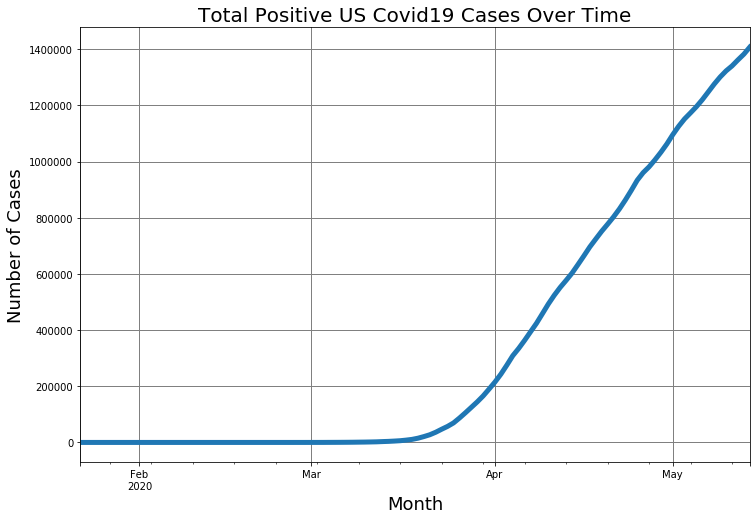

In [5]:
groupedDF = covid_dataframe.groupby(['date'])
positiveseries = groupedDF['positive'].sum()
positiveseries.plot(figsize=(12,8), linewidth=5, legend=False)
plt.grid(color="gray", linestyle='-', linewidth=1)
plt.title("Total Positive US Covid19 Cases Over Time", fontsize=20)
plt.ylabel("Number of Cases", fontsize=18)
plt.xlabel("Month", fontsize=18)
plt.show()

In [6]:
#This creates the S&P dataframe and formats the datetime row
sp500DF = pd.DataFrame(dataframelist, columns=headerslist)
sp500DF['Symbol\n'] = sp500DF['Symbol\n'].str[0:-1]
sp500DF['Founded\n'] = sp500DF['Founded\n'].str[0:-1]
sp500DF['Date first added'] = pd.to_datetime(sp500DF['Date first added'], infer_datetime_format = True, errors='coerce')
sp500DF = sp500DF.rename(columns={'Symbol\n':'Symbol','Founded\n':'Founded'})
# sp500DF

In [7]:
#This joins the industries csv to the sp500 DF
industriesDF = pd.read_csv("Industries.csv")
industriesDF = pd.merge(sp500DF, industriesDF, how='left', left_on="GICS Sub Industry", right_on="GICS Codes/ Sub-industries")
industriesDF = industriesDF[['Symbol', 'Security', 'GICS Sector', 'GICS Sub Industry', 'Headquarters Location', 'Date first added', 'GICS Codes/ Sub-industries', 'NAICS']]
industriesDF

,Symbol,Security,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,GICS Codes/ Sub-industries,NAICS
0,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,Industrial Conglomerates,Manufacturing
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,Health Care Equipment,Health care and social assistance
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,Pharmaceuticals,Health care and social assistance
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,Health Care Equipment,Health care and social assistance
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,IT Consulting & Other Services,"Professional, scientific, and technical services"
...,...,...,...,...,...,...,...,...
501,XYL,Xylem Inc.,Industrials,Industrial Machinery,"White Plains, New York",2011-11-01,Industrial Machinery,Manufacturing
502,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,Restaurants,Accommodation and food services
503,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,Electronic Equipment & Instruments,Manufacturing
504,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,Health Care Equipment,Health care and social assistance


In [8]:
#This pulls S&P data from the Alpha Vantage API
#Note that the S&P changes throughout the year
#Also, we're getting the past 100 days on a rolling basis

ticker_list = list(sp500DF['Symbol'].values)

completeurls = [] # completed urls go here

# stockDF = pd.DataFrame(columns=list(stockDF.columns.values))
stockdata = []

# This generates all URLs and places them in a list so that async can create futures out of them
for stocks in ticker_list:
    completeurls.append(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stocks}&outputsize=compact&apikey={vantage_key}")

nest_asyncio.apply()
async def get_stocks(url):
    connector = aiohttp.TCPConnector(limit=10)
    async with aiohttp.ClientSession(connector=connector, raise_for_status=True) as session:
        async with session.get(url) as response:
            response_content = await response.json()
            response_content['Time Series (Daily)']['symbol'] = url.split("&")[1].split('=')[1] #This extracts the symbol from the URL
            return stockdata.append(response_content['Time Series (Daily)'])

#set up the event loop
asyncio.set_event_loop(asyncio.new_event_loop())
loop = asyncio.get_event_loop()

#add tasks to run
tasks = []
for urls in completeurls:
    future = asyncio.ensure_future(get_stocks(urls))
    tasks.append(future)


#Run
loop.run_until_complete(asyncio.wait(tasks))
# loop.close()


({<Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> exception=ClientConnectorError(ConnectionKey(host='www.alphavantage.co', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None), OSError(24, 'Too many open files'))>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> exception=ClientConnectorError(ConnectionKey(host='www.alphavantage.co', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None), OSError(24, 'Too many open files'))>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> exception=ClientConnectorError(ConnectionKey(host='www.alphavantage.co', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None), OSError(24, 'Too many open files'))>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> exception=ClientConnectorError(ConnectionKey(host='

In [9]:
#This creates the final stockdata dataframe
stockdata = json_normalize(stockdata)
stockDF = pd.DataFrame(stockdata)
stockDF = stockDF.set_index(['symbol'])
stockDF = stockDF.filter(regex='close')
stockDF

,2020-05-14.4. close,2020-05-13.4. close,2020-05-12.4. close,2020-05-11.4. close,2020-05-08.4. close,2020-05-07.4. close,2020-05-06.4. close,2020-05-05.4. close,2020-05-04.4. close,2020-05-01.4. close,...,2020-01-03.4. close,2020-01-02.4. close,2019-12-31.4. close,2019-12-30.4. close,2019-12-27.4. close,2019-12-26.4. close,2019-12-24.4. close,2019-12-23.4. close,2019-12-20.4. close,2020-05-15.4. close
symbol,,,,,,,,,,,,,,,,,,,,,
AMD,54.5100,52.1800,53.7600,55.7400,53.1900,51.9500,52.1600,52.1900,52.5600,49.8800,...,48.6000,49.1000,45.8600,45.5200,46.1800,46.6300,46.5400,45.4600,44.1500,NaN
ATVI,72.9600,73.6700,72.2500,75.4600,73.1400,73.1000,72.8700,68.5300,66.7000,64.7200,...,58.6700,58.6500,59.4200,58.8800,59.1850,58.8900,58.8100,58.8900,59.2200,NaN
ALXN,100.9200,102.4500,101.6500,101.3400,97.3400,96.9200,96.8400,98.2500,103.8400,103.9100,...,106.4100,107.8400,108.1500,107.3400,108.5500,108.9300,110.2800,110.4600,109.7500,NaN
ALK,26.1400,25.5200,26.8500,28.3600,30.0000,28.2500,27.8300,28.9700,28.7700,30.1100,...,66.9200,68.1700,67.7500,67.6800,68.2900,69.0700,69.0900,69.2900,NaN,25.6300
ABMD,184.2700,185.6000,191.2900,194.6100,187.0700,188.3300,186.9100,186.2200,181.0000,183.4900,...,166.8200,168.8100,170.5900,167.2900,169.2700,171.0100,172.3000,170.4400,162.8900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVY,102.2200,102.2600,104.4600,108.8100,109.2600,104.3200,105.7500,106.4900,106.9200,108.0700,...,128.5100,129.3100,130.8200,130.9800,131.6100,133.0800,133.2200,132.8700,NaN,100.4800
BDX,258.7000,261.9200,262.0900,262.0500,254.4800,256.2500,259.1300,261.7000,255.2700,251.8700,...,269.5900,272.5400,271.9700,270.5200,272.8500,271.0600,273.0100,273.4900,NaN,258.2500
COG,18.6500,18.7700,19.0000,19.3500,20.5100,19.9800,19.6000,20.3900,20.2600,20.2200,...,17.2800,17.2300,17.4100,17.1300,17.2200,17.3800,17.4400,17.5900,NaN,18.2500


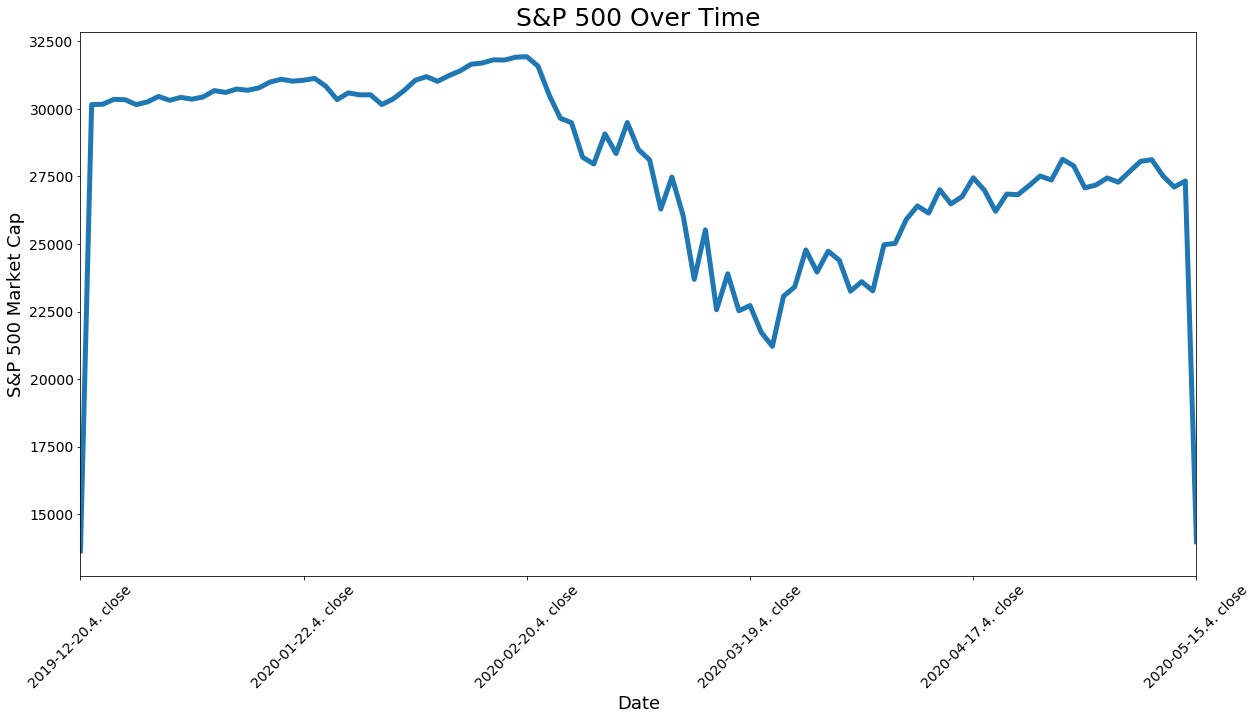

In [10]:
#This creates the final stockdata dataframe
stockDF = stockDF.apply(pd.to_numeric)
# stockDF
stock_visual = stockDF.sum()
stock_visual = stock_visual.sort_index(ascending=True)
stock_visual.plot(figsize=(20,10), linewidth=5, legend=False, fontsize=14)

plt.title("S&P 500 Over Time", fontsize=25)
plt.ylabel("S&P 500 Market Cap", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [11]:
#2019 Population data - US Census Bureau
census_response = requests.get(f"https://api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=state:*&key={census_key}").json()
census_headers = census_response.pop(0)
populationDF = pd.DataFrame(census_response, columns = census_headers)
populationDF = populationDF[populationDF['DATE_CODE']=='12']
populationDF = populationDF[['DENSITY','POP','NAME','STATE']]
# populationDF

#This is 2018 population data
census_response2 = requests.get(f"https://api.census.gov/data/2018/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,STATE&for=state:*&key={census_key}").json()
census_headers2 = census_response2.pop(0)
populationDF2 = pd.DataFrame(census_response2, columns = census_headers2)
populationDF2 = populationDF2[populationDF2['DATE_CODE']=='11']
populationDF2 = populationDF2[['DENSITY','POP','STATE']]
# populationDF2

# total jobs 2018 - from bureau of economic analysis (https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1)
empByIndDF = pd.read_csv("totalEmpIndustry2018.csv")
workers_by_indDF = pd.read_csv("totaljobs2018.csv")

#Create master Dataframe for 2018 data
populationDF = pd.merge(populationDF, populationDF2, how='left', on="STATE", suffixes=['_2019','_2018'])
master_industryDF = pd.merge(empByIndDF, populationDF, right_on='NAME', left_on='GeoName', how='left')
master_industryDF = pd.merge(master_industryDF, workers_by_indDF, left_on='NAME', right_on='GeoName', how='left')
master_industryDF = master_industryDF[['NAME','STATE','LineCode','Description','2018_x','2018_y','POP_2018','POP_2019']]
master_industryDF = master_industryDF.rename(columns={'2018_x':'2018 Workers In Industry',
                                                      '2018_y':'2018 Working Pop',
                                                      'POP_2019':'2019 Overall Population',
                                                      'POP_2018':'2018 Overall Population',
                                                     })

#Imports state list and attaches the abbreviation
stateDF = pd.read_csv("stateabbrs.csv")
master_industryDF = pd.merge(master_industryDF, stateDF, how='left', left_on="NAME", right_on="State")
master_industryDF = master_industryDF[['NAME',
                                       'Code',
                                       'STATE',
                                       'LineCode',
                                       'Description',
                                       '2018 Workers In Industry',
                                       '2018 Working Pop',
                                       '2018 Overall Population',
                                       '2019 Overall Population'
                                       ]]
master_industryDF['2018 Overall Population'] = pd.to_numeric(master_industryDF['2018 Overall Population'])
master_industryDF['2019 Overall Population'] = pd.to_numeric(master_industryDF['2019 Overall Population'])
master_industryDF['2018 Workers In Industry'] = pd.to_numeric(master_industryDF['2018 Workers In Industry'], errors='coerce')
master_industryDF = master_industryDF.dropna(subset=['2018 Workers In Industry']) #This dropped Delaware's logging industry entry. Not sure of the downstream effects
master_industryDF['2018 Percentage of Working Pop'] = (master_industryDF['2018 Workers In Industry'].astype('int64') / master_industryDF['2018 Working Pop']) * 100
# master_industryDF['2019 Working Pop'] = round(master_industryDF['2019 Overall Population'] * (master_industryDF['2018 Percentage of Working Pop'] / 100),0) 
master_industryDF

,NAME,Code,STATE,LineCode,Description,2018 Workers In Industry,2018 Working Pop,2018 Overall Population,2019 Overall Population,2018 Percentage of Working Pop
0,Alabama,AL,01,70,Farm employment,42220.0,2691517,4887871,4903185,1.568632
1,Alabama,AL,01,100,"Forestry, fishing, and related activities",15895.0,2691517,4887871,4903185,0.590559
2,Alabama,AL,01,200,"Mining, quarrying, and oil and gas extra...",10560.0,2691517,4887871,4903185,0.392344
3,Alabama,AL,01,300,Utilities,14176.0,2691517,4887871,4903185,0.526692
4,Alabama,AL,01,400,Construction,148326.0,2691517,4887871,4903185,5.510870
...,...,...,...,...,...,...,...,...,...,...
1066,Wyoming,WY,56,1600,Health care and social assistance,30617.0,405010,577737,578759,7.559566
1067,Wyoming,WY,56,1700,"Arts, entertainment, and recreation",8255.0,405010,577737,578759,2.038221
1068,Wyoming,WY,56,1800,Accommodation and food services,35917.0,405010,577737,578759,8.868176
1069,Wyoming,WY,56,1900,Other services (except government and go...,17920.0,405010,577737,578759,4.424582


In [12]:
# US Bureau of Labor Statistics - Returns unadjusted unemployment rates
areaCodesDF = pd.read_csv("bureauoflaborstats.csv")
fips_dict = pd.read_csv("fipscodes.csv")
fips_dict = fips_dict[["State Abbreviation","FIPS Code"]]
fips_dict = fips_dict.to_dict()

#If we want to get more granular, we can switch the area_type_code from A to N
areaCodesList = areaCodesDF[areaCodesDF["area_type_code"]=="A"]
areaCodesList = list(areaCodesList["area_code"].values)

master_unemp_DF = pd.DataFrame({"year":[],"periodName":[],"value":[],"state":[]})

for x in areaCodesList:
    try:
        seriesid = f"LAU{x}03"
        fips_code = x[2:4]
        headers = {'Content-type': 'application/json'} 
        logging.debug(f"RETRIEVING: {x}, {fips_code}")
        data = json.dumps({"seriesid": [seriesid],"startyear":"2010", "endyear":"2020","registrationkey":bls_key})
        response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers).json()
        state_unemp_DF = pd.DataFrame(response['Results']['series'][0]['data'])
        state_unemp_DF['state'] = fips_dict['State Abbreviation'][int(fips_code)]
        state_unemp_DF = state_unemp_DF[["year","periodName","value","state"]]
        state_unemp_DF['value'] = state_unemp_DF['value'].astype('float')
        master_unemp_DF = master_unemp_DF.append(state_unemp_DF)
    except:
        logging.error(f"Error retrieving data: {x}")


ERROR:root:Error retrieving data: ST5500000000000
ERROR:root:Error retrieving data: ST5600000000000
ERROR:root:Error retrieving data: ST7200000000000


In [13]:
master_unemp_DF

,year,periodName,value,state
0,2020,March,3.3,AL
1,2020,February,2.9,AL
2,2020,January,3.2,AL
3,2019,December,2.5,AL
4,2019,November,2.4,AL
...,...,...,...,...
118,2010,May,8.3,WY
119,2010,April,8.4,WY
120,2010,March,9.3,WY
121,2010,February,10.0,WY


In [14]:
# Create Unemployment rate DF and format month name to numeric
#master_unemp_DFx = master_unemp_DF
#master_unemp_DFx['periodName']  = master_unemp_DFx['periodName'].apply(lambda x: time.strptime(str(x), '%m'))
#master_unemp_DFx = master_unemp_DFx.rename(columns={'periodName':'month'})
#master_unemp_DFx = pd.pivot_table(master_unemp_DFx, index=['state','month'], columns=['year'], values=['value'])
#master_unemp_DFx


In [15]:
msx = master_unemp_DF[master_unemp_DF["year"] == "2020"]
msx_cleaned = msx[msx["value"] != "nan"]
msx_cleaned['periodName']  = msx_cleaned['periodName'].apply(lambda x: time.strptime(x, '%B').tm_mon)
msx_cleaned = msx_cleaned.rename(columns={'periodName':'month'})
msx_cleaned.sort_values(by=["state","month"])


/Users/heatherjanemoore/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,year,month,value,state
2,2020,1,3.2,AL
1,2020,2,2.9,AL
0,2020,3,3.3,AL
2,2020,1,6.6,AR
1,2020,2,5.9,AR
...,...,...,...,...
1,2020,2,4.2,WV
0,2020,3,5.3,WV
2,2020,1,5.5,WY
1,2020,2,5.5,WY


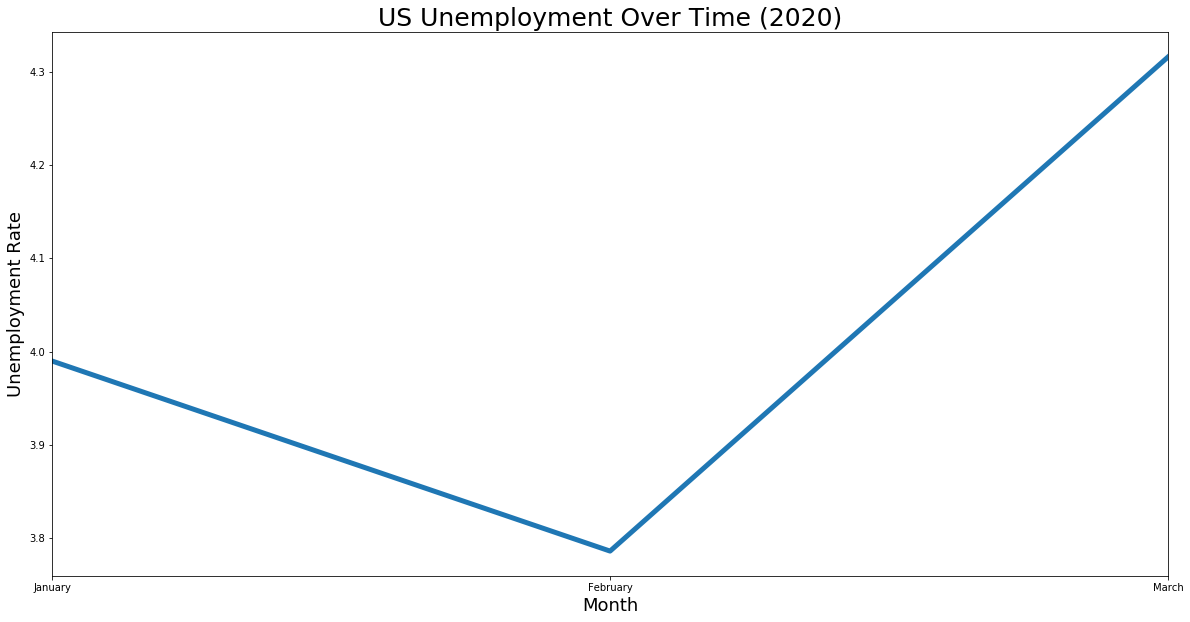

In [16]:
#msx_cleaned.plot()
msxgroupedDF = msx_cleaned.groupby(['month'])
msxAVG = msxgroupedDF['value'].mean()
msxAVG.plot(figsize=(20,10), linewidth=5, legend=False)

locs, labels = plt.xticks() 
plt.xticks([1,2,3], ['January', 'February', 'March']) 

plt.title("US Unemployment Over Time (2020)", fontsize=25)
plt.ylabel("Unemployment Rate", fontsize=18)
plt.xlabel("Month", fontsize=18)
plt.show()
#fig.savefig('Unemployment_line.png')

/Users/heatherjanemoore/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


state
AL    AxesSubplot(0.125,0.125;0.775x0.755)
AR    AxesSubplot(0.125,0.125;0.775x0.755)
AZ    AxesSubplot(0.125,0.125;0.775x0.755)
CA    AxesSubplot(0.125,0.125;0.775x0.755)
CO    AxesSubplot(0.125,0.125;0.775x0.755)
DC    AxesSubplot(0.125,0.125;0.775x0.755)
DE    AxesSubplot(0.125,0.125;0.775x0.755)
FL    AxesSubplot(0.125,0.125;0.775x0.755)
GA    AxesSubplot(0.125,0.125;0.775x0.755)
GU    AxesSubplot(0.125,0.125;0.775x0.755)
HI    AxesSubplot(0.125,0.125;0.775x0.755)
ID    AxesSubplot(0.125,0.125;0.775x0.755)
IL    AxesSubplot(0.125,0.125;0.775x0.755)
IN    AxesSubplot(0.125,0.125;0.775x0.755)
KS    AxesSubplot(0.125,0.125;0.775x0.755)
KY    AxesSubplot(0.125,0.125;0.775x0.755)
LA    AxesSubplot(0.125,0.125;0.775x0.755)
MA    AxesSubplot(0.125,0.125;0.775x0.755)
MD    AxesSubplot(0.125,0.125;0.775x0.755)
ME    AxesSubplot(0.125,0.125;0.775x0.755)
MI    AxesSubplot(0.125,0.125;0.775x0.755)
MN    AxesSubplot(0.125,0.125;0.775x0.755)
MO    AxesSubplot(0.125,0.125;0.775x0.755)
MS   

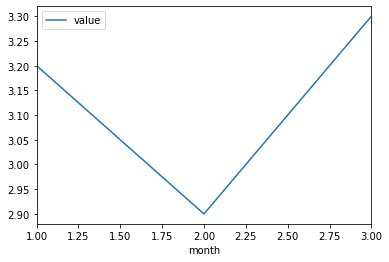

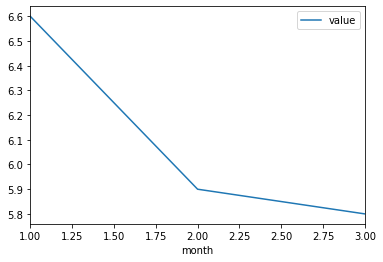

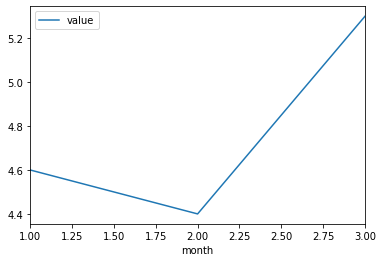

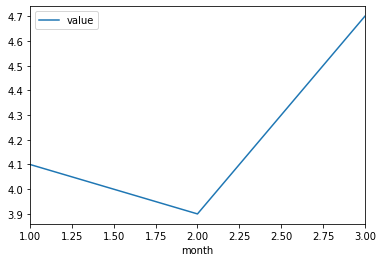

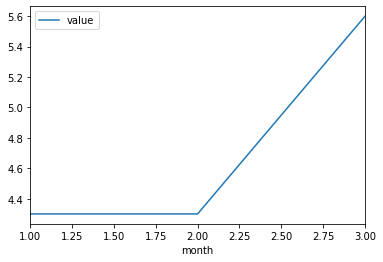

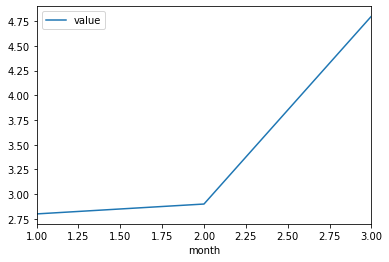

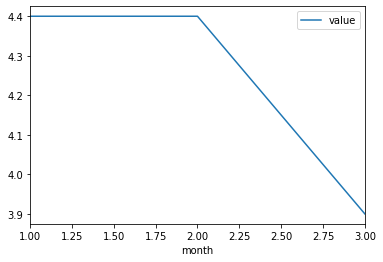

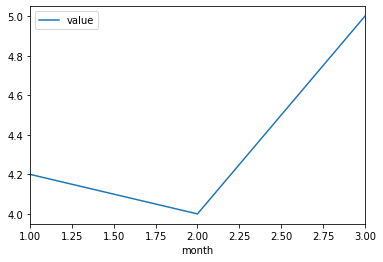

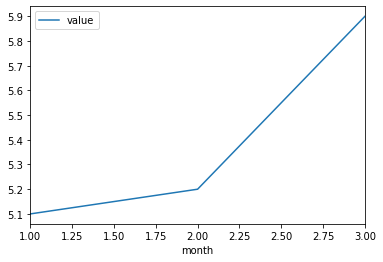

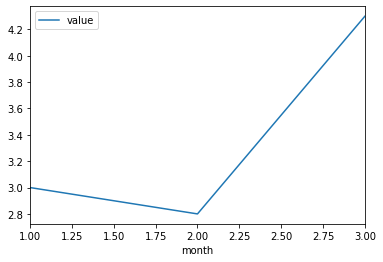

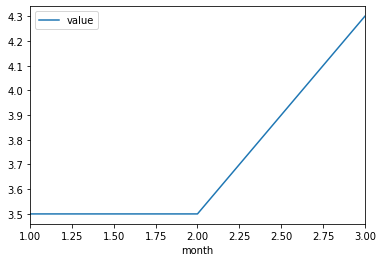

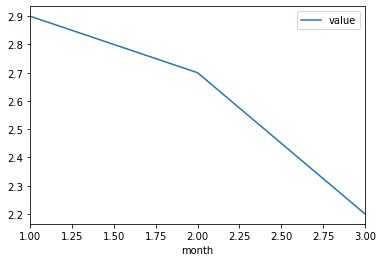

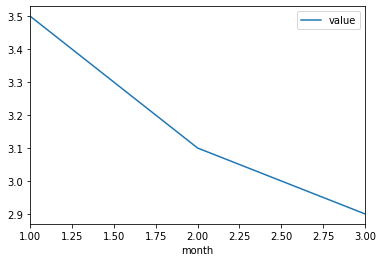

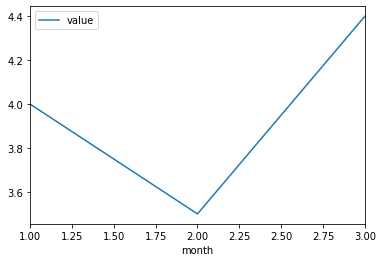

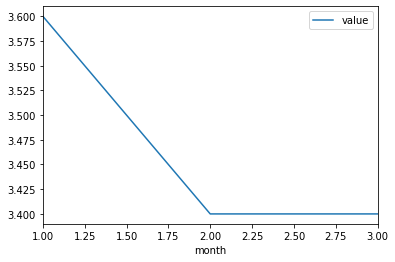

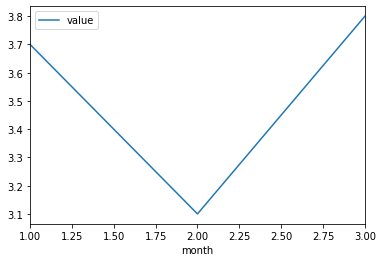

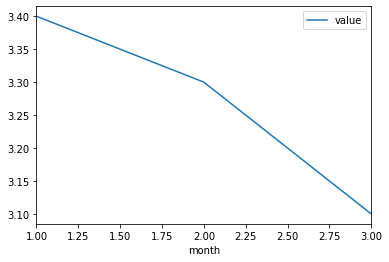

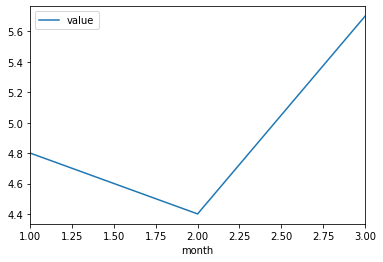

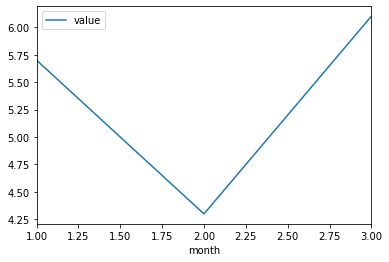

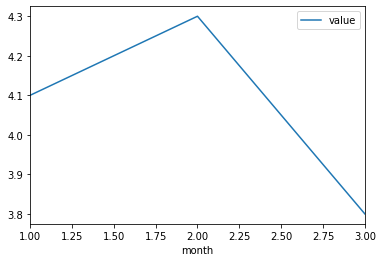

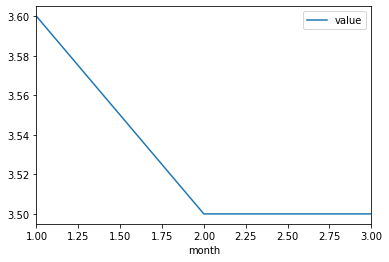

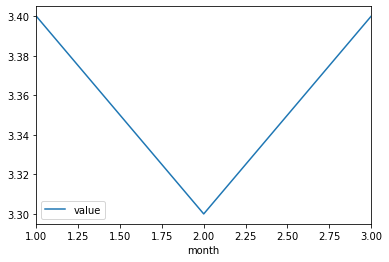

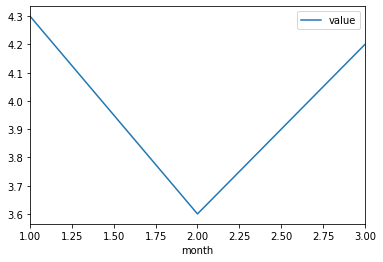

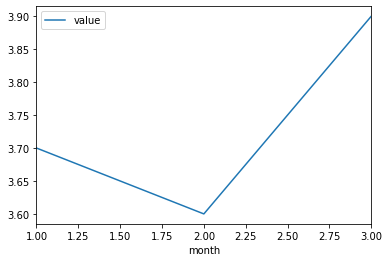

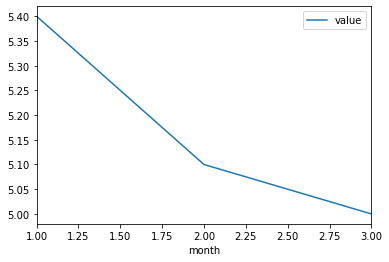

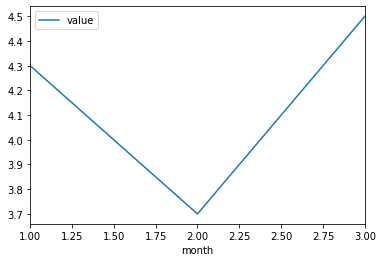

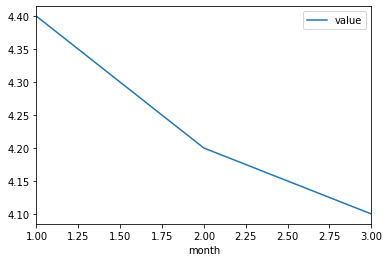

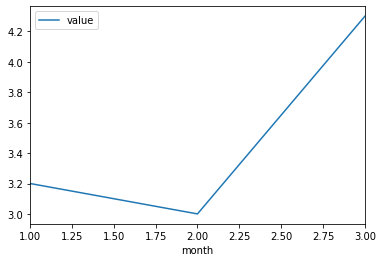

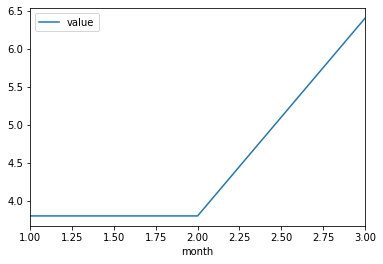

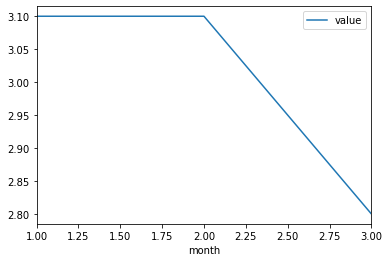

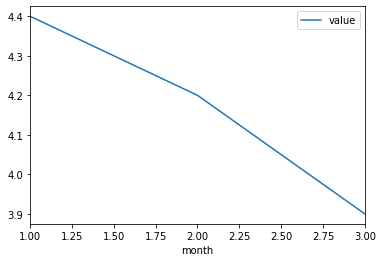

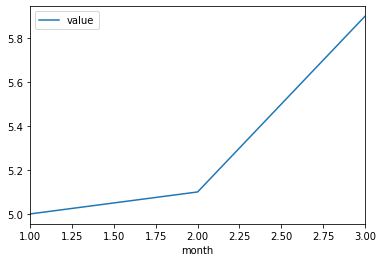

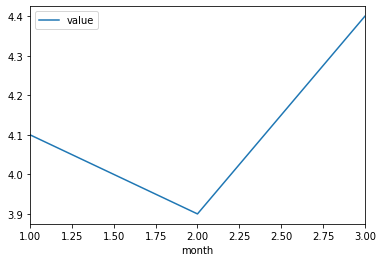

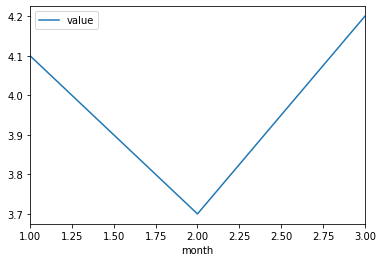

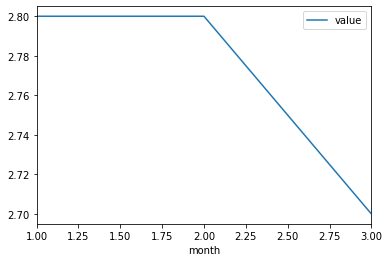

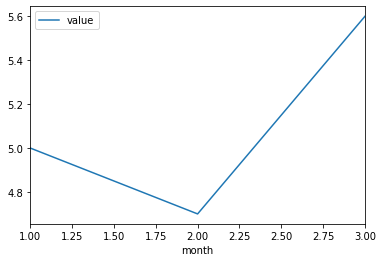

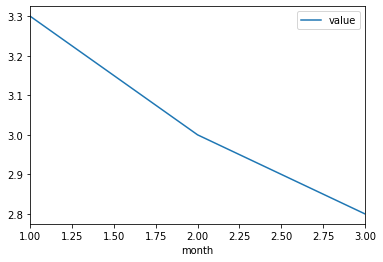

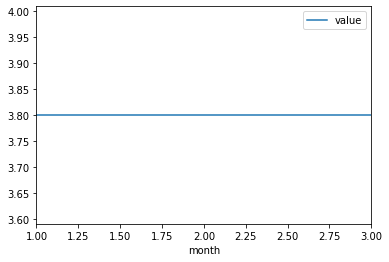

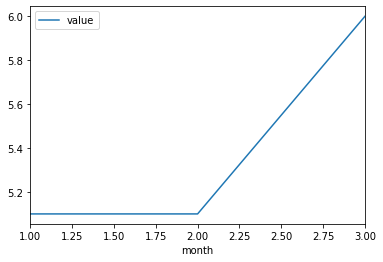

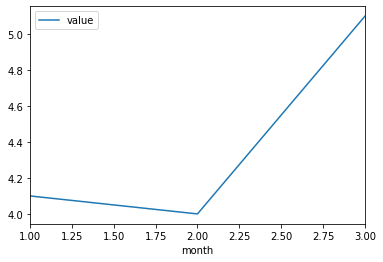

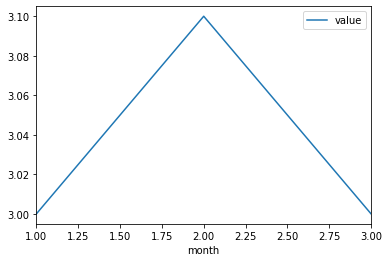

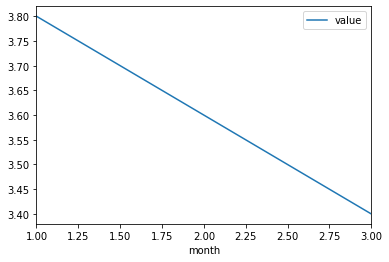

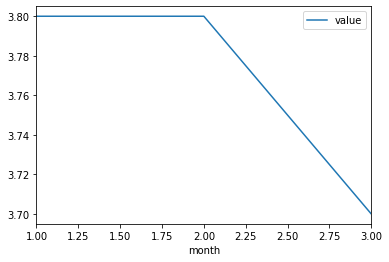

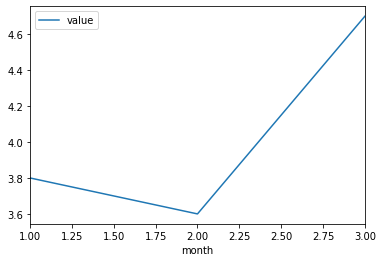

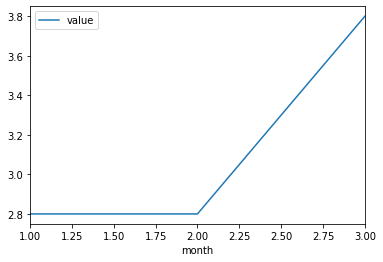

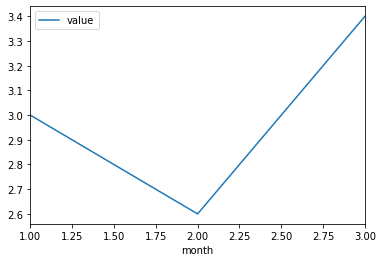

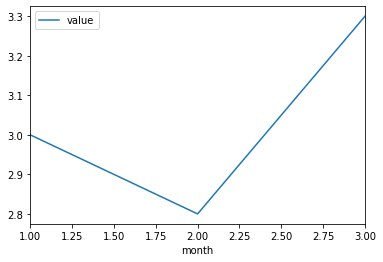

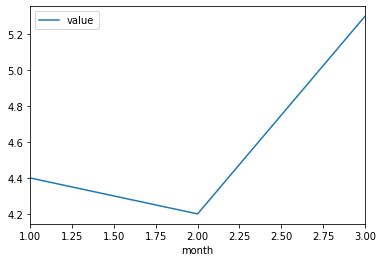

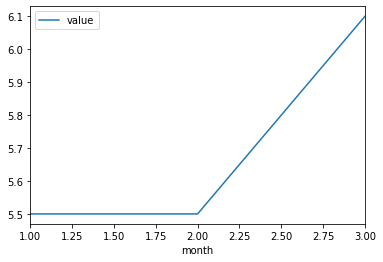

In [17]:
msx_cleaned.groupby('state').plot(x='month', y='value', )

state
CA    AxesSubplot(0.125,0.125;0.775x0.755)
FL    AxesSubplot(0.125,0.125;0.775x0.755)
HI    AxesSubplot(0.125,0.125;0.775x0.755)
MD    AxesSubplot(0.125,0.125;0.775x0.755)
MI    AxesSubplot(0.125,0.125;0.775x0.755)
NV    AxesSubplot(0.125,0.125;0.775x0.755)
NY    AxesSubplot(0.125,0.125;0.775x0.755)
TX    AxesSubplot(0.125,0.125;0.775x0.755)
VA    AxesSubplot(0.125,0.125;0.775x0.755)
WA    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

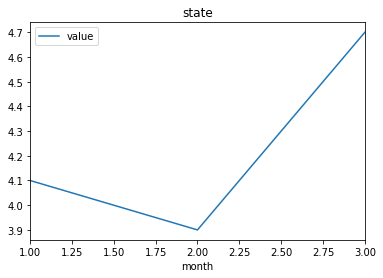

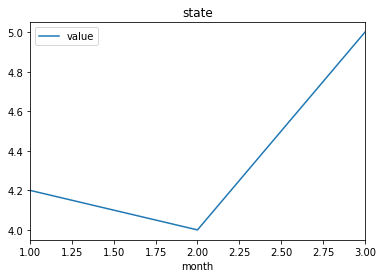

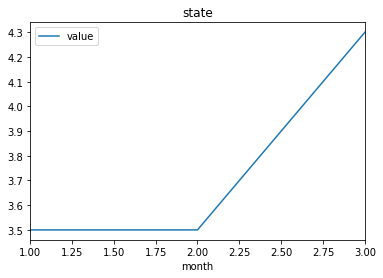

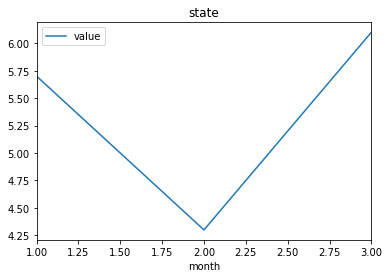

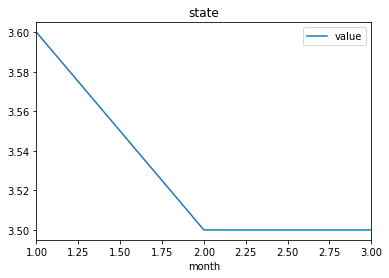

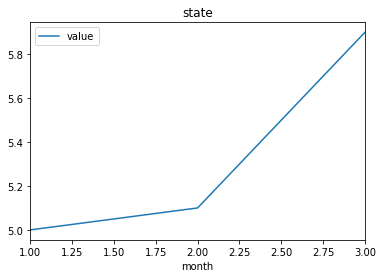

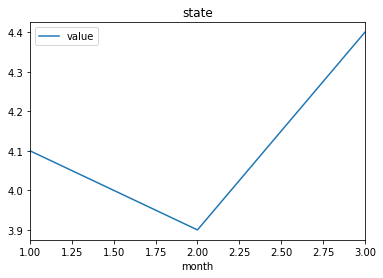

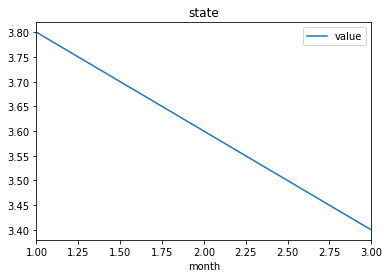

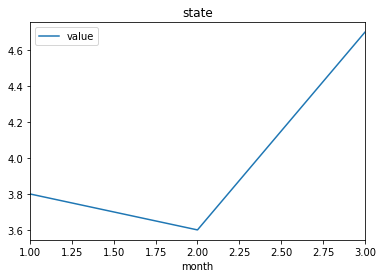

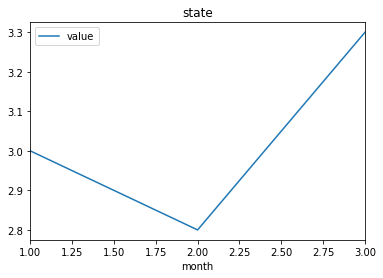

In [18]:
msxSelectStates = msx_cleaned[msx_cleaned["state"].isin(["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"])]
msxSelectStates.groupby('state').plot(x='month', y='value', legend=True, title = "state")

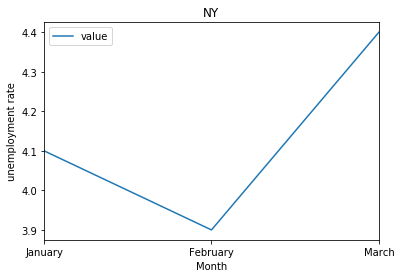

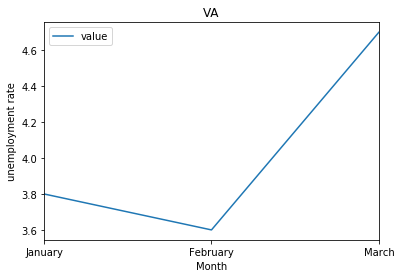

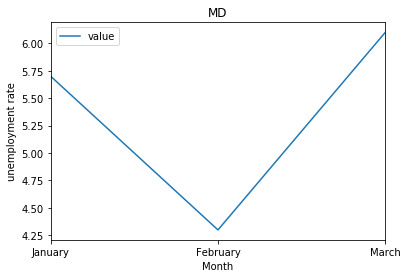

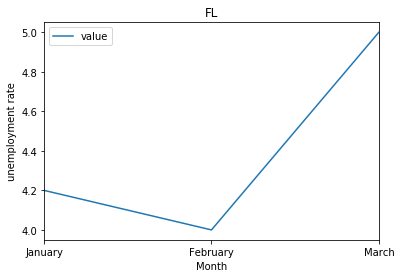

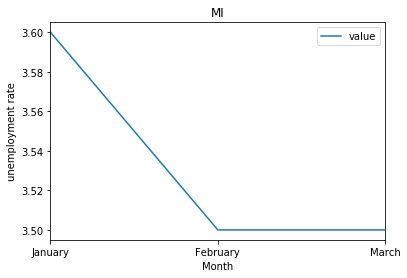

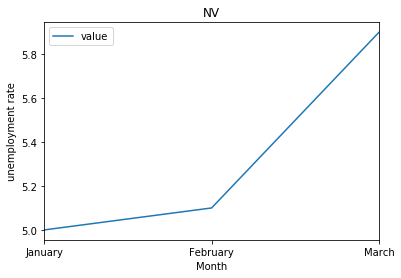

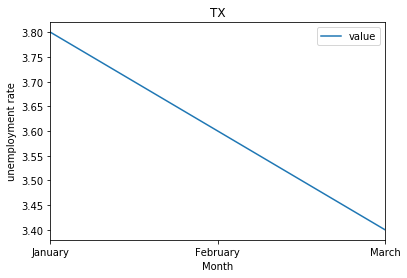

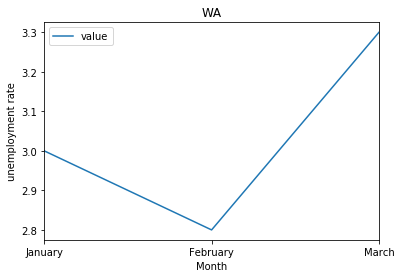

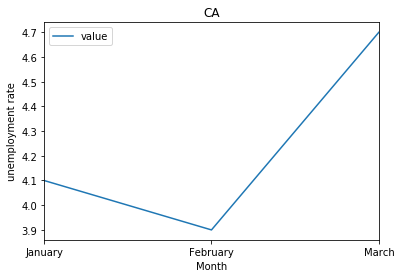

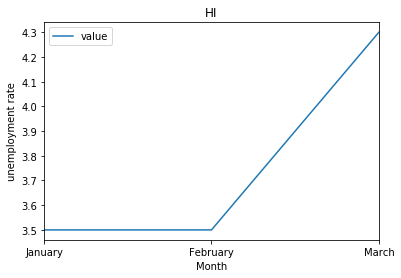

In [19]:
states = ["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"]
for state in states:
    msxSelectStates1 = msx_cleaned[msx_cleaned["state"] == state]
    msxSelectStates1.groupby('state').plot(x='month', y='value', legend=True, title = state)
    locs, labels = plt.xticks() 
    plt.xticks([1,2,3], ['January', 'February', 'March']) 
    plt.ylabel("unemployment rate")
    plt.xlabel("Month")
    plt.show()
    

Text(0.5, 1.0, 'US Unemployment Over Time')

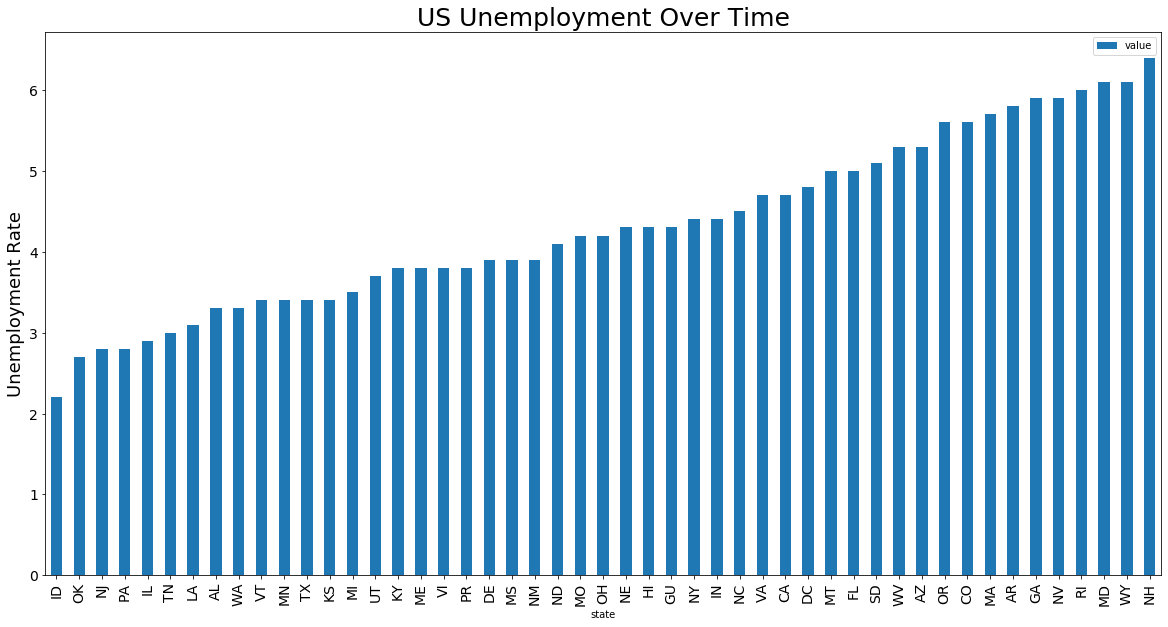

In [20]:
msx_cleaned[msx_cleaned['month']==3].sort_values("value").plot.bar(x='state', y='value', fontsize=14, figsize=(20,10))
plt.ylabel("Unemployment Rate", fontsize=18)
plt.title("US Unemployment Over Time", fontsize=25)
#fig.savefig('Unemployment_graph.png')

Text(0.5, 1.0, 'Unemployment Rate Across Sample States')

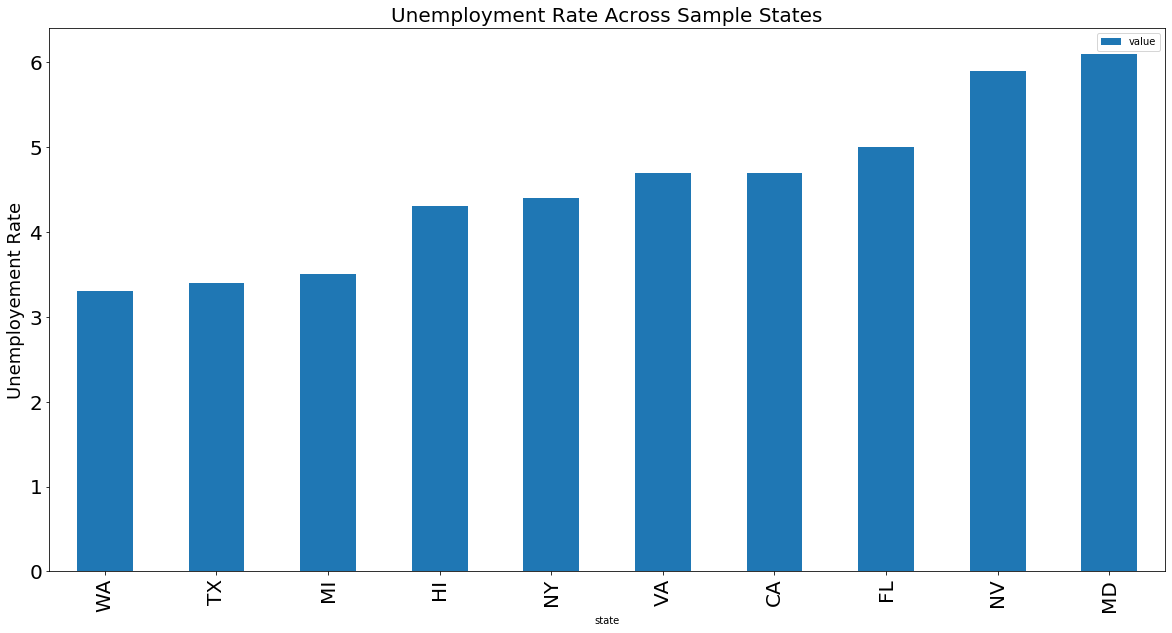

In [21]:
states = ["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"]
msx_finalmonth = msx_cleaned[msx_cleaned['month']==3].sort_values("value")
msx_finalmonth[msx_finalmonth["state"].isin(states)].plot.bar(x='state', y='value', fontsize=20, figsize=(20,10))
plt.ylabel("Unemployment by States in March", fontsize=18)
plt.ylabel("Unemployement Rate", fontsize=18)
plt.title("Unemployment Rate Across Sample States", fontsize=20)
#fig.savefig('graph.png')